# New York City Taxi Fare Prediction 

Import pandas, xgboost

In [1]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm



NY Taxi data files

In [2]:
nytaxi_data_dir='/mnt/c/Users/hkver/Documents/dbai/nytaxidata/'
os.listdir(nytaxi_data_dir)

['GCP-Coupons-Instructions.rtf',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'train_full.csv']

## Data cleaning & Feature engineering Methods

In [3]:
def remove_outliers(df):
    df = df.dropna()
    mask = df['fare_amount'].between(0, 500)
    mask &= df['passenger_count'].between(0, 6)

    # to select coordinates: https://www.openstreetmap.org/export
    mask &= df['pickup_longitude'].between(-75, -73)
    mask &= df['dropoff_longitude'].between(-75, -73)
    mask &= df['pickup_latitude'].between(40, 42)
    mask &= df['dropoff_latitude'].between(40, 42)

    return df[mask]

def manhattan(pickup, dropoff):
    pickup_long, pickup_lat = pickup
    dropoff_long, dropoff_lat = dropoff
    return np.abs(dropoff_long - pickup_long) + np.abs(dropoff_lat - pickup_lat)

def extract_distance_features(df):
    df['abs_diff_longitude'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()
    df['abs_diff_latitude'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()

    pickup = (df['pickup_longitude'], df['pickup_latitude'])
    dropoff = (df['dropoff_longitude'], df['dropoff_latitude'])
    df['distance'] = manhattan(pickup, dropoff)

    # Distances to nearby airports, and city center
    # https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    coordinates = {
        'nyc': (-74.0063889, 40.7141667),
        'jfk': (-73.7822222222, 40.6441666667),
        'ewr': (-74.175, 40.69),
        'lgr': (-73.87, 40.77)
    }

    for name, coord in coordinates.items():
        df[f'pickup_distance_to_{name}'] = manhattan(coord, pickup)
        df[f'dropoff_distance_to_{name}'] = manhattan(coord, dropoff)

    return df

def extract_datetime_features(df):
    # Removing unecessary information from the datetime string
    # https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    pickup_datetime = df['pickup_datetime'].str.slice(0, 16)
    pickup_datetime = pd.to_datetime(pickup_datetime, utc=True, format='%Y-%m-%d %H:%M')

    df['year'] = pickup_datetime.dt.year
    df['month'] = pickup_datetime.dt.month
    df['day'] = pickup_datetime.dt.day
    df['dayofweek'] = pickup_datetime.dt.dayofweek
    df['hour'] = pickup_datetime.dt.hour

    return df.drop(columns='pickup_datetime')

def extract_features(df):
    df = extract_distance_features(df)
    df = extract_datetime_features(df)
    return df

### Create batched train data using pandas data frames

In [4]:
def create_batch_pandas_df(batch_size=1000, val_size=10):
    dtypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

    input_file = nytaxi_data_dir+'train.csv'

    val_df = pd.read_csv(input_file, usecols=dtypes.keys(), dtype=dtypes, nrows=val_size)
    val_df = remove_outliers(val_df)
    val_df = extract_features(val_df)

    X_val = val_df.drop(columns='fare_amount')
    y_val = val_df[['fare_amount']]
    dval = xgb.DMatrix(X_val, y_val, feature_names=X_val.columns)

    columns = pd.read_csv(input_file, nrows=0).columns
    train_df = pd.read_csv(input_file, usecols=dtypes.keys(), dtype=dtypes,
                       names=columns, skiprows=val_size + 1,
                       chunksize=batch_size)
    
    return [dval, train_df]

## Create batch train data using arrow data frame

## Batch training function

In [5]:
def train_batch(batch_df, model, params, num_rounds, dval):
    batch_df = remove_outliers(batch_df)
    batch_df = extract_features(batch_df)

    X_train = batch_df.drop(columns='fare_amount')
    y_train = batch_df[['fare_amount']]
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
    
    model = xgb.train(params, dtrain, num_rounds, early_stopping_rounds=5,
                      evals=[(dtrain, 'train'), (dval, 'eval')],
                      xgb_model=model)
    return model

## Train using pandas data frame

In [6]:
def train_using_pandas_df():
    params = {'learning_rate': 0.05,
              'max_depth': 7,
              'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'subsample': 0.8,
              'gamma': 1,
              'silent': True,
              'verbose_eval': True}
    num_rounds = 16
    model = None
    batch_size = 1000
    val_size = 10
    [dval, train_df] = create_batch_pandas_df(batch_size=batch_size, val_size=val_size)
    for batch_df in tqdm(train_df):
        model = train_batch(batch_df=batch_df, model=model, params=params, 
                           num_rounds=num_rounds, dval=dval)
    return model

Train using arrow record batch

In [7]:
model = train_using_pandas_df()
#model = train_using_arrows()

0it [00:00, ?it/s]

[16:09:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:13.94877	eval-rmse:9.31146
[1]	train-rmse:13.33901	eval-rmse:8.82978
[2]	train-rmse:12.76403	eval-rmse:8.30733
[3]	train-rmse:12.21894	eval-rmse:7.86610
[4]	train-rmse:11.69665	eval-rmse:7.47604
[5]	train-rmse:11.19774	eval-rmse:7.05821
[6]	train-rmse:10.73895	eval-rmse:6.71583
[7]	train-rmse:10.28491	eval-rmse:6.39070
[8]	train-rmse:9.85404	eval-rmse:6.07283
[9]	train-rmse:9.44794	eval-rmse:5.74019
[10]	train-rmse:9.06616

1it [00:00,  4.18it/s]

[16:09:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:9.79401	eval-rmse:4.06866
[1]	train-rmse:9.46665	eval-rmse:3.91708
[2]	train-rmse:9.14045	eval-rmse:3.78884
[3]	train-rmse:8.90878	eval-rmse:3.63326
[4]	train-rmse:8.73471	eval-rmse:3.51168
[5]	train-rmse:8.43836	eval-rmse:3.36795
[6]	train-rmse:8.16269	eval-rmse:3.23547
[7]	train-rmse:7.93229	eval-rmse:3.13332
[8]	train-rmse:7.68408	eval-rmse:3.02285
[9]	train-rmse:7.55366	eval-rmse:2.90689
[10]	train-rmse:7.39037	eval-rmse:2.81427
[11]	train-rmse:7.15420	eval-rmse:2.73421
[12]	train-rmse:6.92939	eval-rmse:2.65473
[13]	train-rmse:6.78230	eval-rmse:2.59773
[14]	train-rmse:6.59582	eval-rms

2it [00:00,  2.54it/s]

[16:09:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:5.01673	eval-rmse:2.41458
[1]	train-rmse:4.88026	eval-rmse:2.35819
[2]	train-rmse:4.75728	eval-rmse:2.32727
[3]	train-rmse:4.65122	eval-rmse:2.26535
[4]	train-rmse:4.52421	eval-rmse:2.23034
[5]	train-rmse:4.41654	eval-rmse:2.19317
[6]	train-rmse:4.30724	eval-rmse:2.17135
[7]	train-rmse:4.21153	eval-rmse:2.15203
[8]	train-rmse:4.12959	eval-rmse:2.11727
[9]	train-rmse:4.03761	eval-rmse:2.07304
[10]	train-rmse:3.95106	eval-rmse:2.07564
[11]	train-rmse:3.87724	eval-rmse:2.04775
[12]	train-rmse:3.82451	eval-rmse:1.99114
[13]	train-rmse:3.73737	eval-rmse:1.95967
[14]	train-rmse:3.66248	eval-rms

3it [00:01,  2.68it/s]

[16:09:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.55409	eval-rmse:1.93625
[1]	train-rmse:3.48459	eval-rmse:1.90554
[2]	train-rmse:3.40474	eval-rmse:1.91884
[3]	train-rmse:3.34068	eval-rmse:1.91591
[4]	train-rmse:3.27803	eval-rmse:1.91000
[5]	train-rmse:3.20646	eval-rmse:1.91860
[6]	train-rmse:3.14745	eval-rmse:1.89130
[7]	train-rmse:3.08459	eval-rmse:1.91705
[8]	train-rmse:3.02388	eval-rmse:1.90708
[9]	train-rmse:2.96740	eval-rmse:1.96982
[10]	train-rmse:2.92519	eval-rmse:1.97475
[11]	train-rmse:2.87474	eval-rmse:1.97218


4it [00:01,  2.90it/s]

[16:09:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.56841	eval-rmse:1.98000
[1]	train-rmse:4.46707	eval-rmse:1.97951
[2]	train-rmse:4.38090	eval-rmse:1.97793
[3]	train-rmse:4.28829	eval-rmse:1.97775
[4]	train-rmse:4.19400	eval-rmse:1.97768
[5]	train-rmse:4.13733	eval-rmse:1.97772
[6]	train-rmse:4.07278	eval-rmse:2.00244
[7]	train-rmse:4.01761	eval-rmse:2.00247
[8]	train-rmse:3.96296	eval-rmse:2.00277


5it [00:01,  3.22it/s]

[16:09:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.64335	eval-rmse:1.98880
[1]	train-rmse:4.55063	eval-rmse:1.98911
[2]	train-rmse:4.45031	eval-rmse:1.98955
[3]	train-rmse:4.36316	eval-rmse:2.05332
[4]	train-rmse:4.28411	eval-rmse:2.05350
[5]	train-rmse:4.21719	eval-rmse:2.05421


6it [00:01,  3.99it/s]

[16:09:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.02187	eval-rmse:2.03532
[1]	train-rmse:3.95558	eval-rmse:2.04007
[2]	train-rmse:3.90436	eval-rmse:2.03965
[3]	train-rmse:3.84980	eval-rmse:2.07187
[4]	train-rmse:3.78538	eval-rmse:2.06844
[5]	train-rmse:3.72421	eval-rmse:2.05441


7it [00:01,  4.61it/s]

[16:09:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.40689	eval-rmse:2.12120
[1]	train-rmse:4.35360	eval-rmse:2.10290
[2]	train-rmse:4.26672	eval-rmse:2.10301
[3]	train-rmse:4.22410	eval-rmse:2.11147
[4]	train-rmse:4.14672	eval-rmse:2.11167
[5]	train-rmse:4.06297	eval-rmse:2.11269
[6]	train-rmse:3.98365	eval-rmse:2.11348


8it [00:02,  4.93it/s]

[16:09:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.77797	eval-rmse:2.04384
[1]	train-rmse:3.70554	eval-rmse:1.96195
[2]	train-rmse:3.63170	eval-rmse:1.90744
[3]	train-rmse:3.58069	eval-rmse:1.93612
[4]	train-rmse:3.54872	eval-rmse:1.93603
[5]	train-rmse:3.48935	eval-rmse:1.92491
[6]	train-rmse:3.45231	eval-rmse:1.92456
[7]	train-rmse:3.39158	eval-rmse:1.90275
[8]	train-rmse:3.33769	eval-rmse:1.91108
[9]	train-rmse:3.29095	eval-rmse:1.91120
[10]	train-rmse:3.24096	eval-rmse:1.90923
[11]	train-rmse:3.20949	eval-rmse:1.90395
[12]	train-rmse:3.16219	eval-rmse:1.90401


9it [00:02,  4.70it/s]

[16:09:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.92949	eval-rmse:1.91202
[1]	train-rmse:3.87935	eval-rmse:1.91803
[2]	train-rmse:3.81246	eval-rmse:1.91592
[3]	train-rmse:3.78669	eval-rmse:1.93111
[4]	train-rmse:3.72506	eval-rmse:1.93095
[5]	train-rmse:3.67186	eval-rmse:1.93112


10it [00:02,  4.03it/s]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

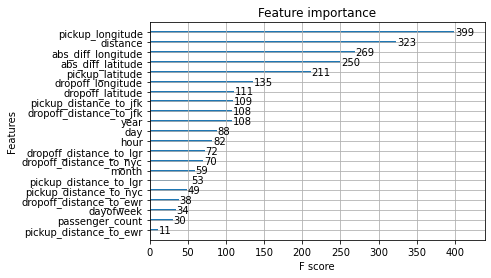

In [8]:
xgb.plot_importance(model)

## Predictions

In [9]:
test_df = pd.read_csv(nytaxi_data_dir+'test.csv')
test_df = extract_features(test_df)
test_df.dtypes

key                         object
pickup_longitude           float64
pickup_latitude            float64
dropoff_longitude          float64
dropoff_latitude           float64
passenger_count              int64
abs_diff_longitude         float64
abs_diff_latitude          float64
distance                   float64
pickup_distance_to_nyc     float64
dropoff_distance_to_nyc    float64
pickup_distance_to_jfk     float64
dropoff_distance_to_jfk    float64
pickup_distance_to_ewr     float64
dropoff_distance_to_ewr    float64
pickup_distance_to_lgr     float64
dropoff_distance_to_lgr    float64
year                         int64
month                        int64
day                          int64
dayofweek                    int64
hour                         int64
dtype: object

In [10]:
X_test = test_df.drop(columns='key')
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns)
y_pred = model.predict(dtest)

submission = pd.DataFrame({'key': test_df['key'], 'fare_amount': y_pred})
submission.to_csv('submission.csv', index = False)

!head submission.csv

key,fare_amount
2015-01-27 13:08:24.0000002,8.855905
2015-01-27 13:08:24.0000003,8.974336
2011-10-08 11:53:44.0000002,5.0169454
2012-12-01 21:12:12.0000002,7.810642
2012-12-01 21:12:12.0000003,13.461243
2012-12-01 21:12:12.0000005,10.280563
2011-10-06 12:10:20.0000001,5.234773
2011-10-06 12:10:20.0000003,42.901
2011-10-06 12:10:20.0000002,10.963152
